In [29]:
import numpy as np 
import pandas as pd
import re 

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
import spacy

import nltk
from nltk.stem.snowball import SnowballStemmer

In [3]:
WORK_DIR = Path.cwd()
DATA_DIR = Path.cwd()/'data'

## Data Cleaning and Preprocessing

In [4]:
train = pd.read_csv(DATA_DIR/'raw/train.csv')
test = pd.read_csv(DATA_DIR/'raw/test.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [19]:
train = train.fillna('missing')
test = test.fillna('missing')
train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', ' ').lower())
test['keyword'] = test['keyword'].apply(lambda x: x.replace('%20', ' ').lower())

words = len([word for word in test.keyword.unique() if word not in train.keyword.unique()])
print(f'{words} Keywords in Test But not in Train')

0 Keywords in Test But not in Train


In [9]:
# Location is too fine-grained and maynot be useful 
train.location.fillna('missing').apply(lambda x: x.lower()).value_counts()

missing                      2533
usa                           104
new york                       75
united states                  50
london                         49
                             ... 
friendswood, tx                 1
nigeria, worldwide              1
sligo and galway, ireland       1
brizzle city !                  1
ìït: 33.209923,-87.545328       1
Name: location, Length: 3234, dtype: int64

In [10]:
# May need to stem some of these words eg. wounded/wounds
train.keyword.fillna('missing').value_counts().sort_index()

ablaze               36
accident             35
aftershock           34
airplane accident    35
ambulance            38
                     ..
wounded              37
wounds               33
wreck                37
wreckage             39
wrecked              39
Name: keyword, Length: 222, dtype: int64

<AxesSubplot:>

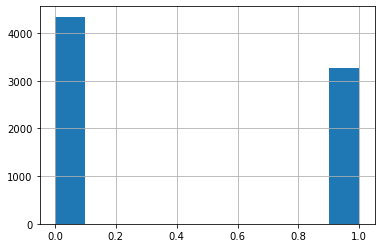

In [11]:
# So no imbalance class problem
train.target.hist()

In [12]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

def lemmatize_text(text): 
    return (' '.join([token.lemma_ for token in nlp(text.lower()) if (token.text not in stop_words)]).replace('# ', ''))

def extract_hashtag(tweet):
    split_tweet = tweet.split('#')
    if len(split_tweet)>1:
        hashtags = [hashtag.split()[0] for hashtag in split_tweet[1:] if len(hashtag)>=1]
        return ' '.join(sorted(hashtags))
    else:
        return 'missing'

In [187]:
# Lemmatize keywords
lemmatized_kw = [lemmatize_text(x) for x in train.keyword.unique()]
lemmatized_dict = dict(zip(train.keyword.unique(), lemmatized_kw))
train['keyword_processed'] = train.keyword.map(lemmatized_dict)
train['keyword_processed'] = train['keyword_processed'].apply(lambda x: ''.join(x.split(' ')))

test['keyword_processed'] = test.keyword.map(lemmatized_dict)
test['keyword_processed'] = test['keyword_processed'].apply(lambda x: ''.join(x.split(' ')))

## Lemmatize main body text
train['text_processed'] = train.text.apply(lambda x: lemmatize_text(x))
test['text_processed'] = test.text.apply(lambda x: lemmatize_text(x))

# Extracting Hashtags
train['hashtags'] = train.text.apply(lambda x: extract_hashtag(x))
test['hashtags'] = test.text.apply(lambda x: extract_hashtag(x))

# Using regex to clean up different links
train['text_processed'] = train.text_processed.apply(lambda x: re.sub('http://[aA-zZ0-9\/\.]+',  'http', x))
test['text_processed'] = test.text_processed.apply(lambda x:  re.sub('http://[aA-zZ0-9\/\.]+',  'http', x))

# Drop duplicates tweets for train test
train = train.drop_duplicates('text')

In [178]:
x = 'http://t.co/mkWyvM3i8r'
re.sub('http://[aA-zZ0-9\/\.]+',  '-website-', x)

'-website-'

In [174]:
train.to_pickle(DATA_DIR/'interim/train.pkl')
test.to_pickle(DATA_DIR/'interim/test.pkl')

In [138]:
word_vector = np.array([token.vector for token in nlp(train.text_processed[0])]).shape

In [139]:
word_vector

(5, 96)

## EDA And Visualization

#### A1. Comparing Keywords Prevalence of Actual Disaster

In [20]:
kw_ohe = pd.get_dummies(train['keyword'],drop_first=True)
train_merged = train.merge(kw_ohe, left_index=True, right_index=True)

In [27]:
kw_val = train_merged.iloc[:, 8:].values
num_disaster = np.array([np.sum(train.target.values * kw_val[:, num]) for num in range(kw_val.shape[1])])

kw_count = train_merged.iloc[:, 8:].sum()
kw_proba = pd.Series(num_disaster/kw_count.values, index=kw_count.index)
kw_proba.sort_values()

aftershock    0.000000
body bags     0.024390
ruin          0.027027
blazing       0.029412
body bag      0.030303
                ...   
typhoon       0.973684
outbreak      0.975000
debris        1.000000
derailment    1.000000
wreckage      1.000000
Length: 221, dtype: float64

In [72]:
# separating Keywords into either groups that has high probability with 0 or 1
low_kw = list(kw_proba.sort_values()[0:50].index)
high_kw = list(kw_proba.sort_values()[-50:].index)
main_kw = low_kw + high_kw
all_kw = kw_proba.index

#### A2. Body Text Prevalence of Actual Disaster

In [148]:
count = CountVectorizer(ngram_range=(1,1), min_df=20)

In [149]:
count = CountVectorizer(ngram_range=(2,2), min_df=20)

In [150]:
tfidf = TfidfVectorizer(ngram_range=(2,2), min_df=10)

In [151]:
vectorized = count.fit_transform(train['text_processed'])
vector = pd.DataFrame(np.c_[vectorized.toarray(), np.array(train.target)], columns = count.get_feature_names()+['target'])

In [85]:
vectorized = tfidf.fit_transform(train['text_processed'])
vector = pd.DataFrame(np.c_[vectorized.toarray(), np.array(train.target)], columns = tfidf.get_feature_names()+['target'])

In [ ]:
def calc_prevalence(df, target_col): 
    df

In [153]:
train

,id,keyword,location,text,target,keyword_processed,text_processed,hashtags
0,1,missing,missing,Our Deeds are the Reason of this #earthquake M...,1,miss,deed reason earthquake allah forgive,earthquake
1,4,missing,missing,Forest fire near La Ronge Sask. Canada,1,miss,forest fire near la ronge sask . canada,missing
2,5,missing,missing,All residents asked to 'shelter in place' are ...,1,miss,resident ask ' shelter place ' notify officer ...,missing
3,6,missing,missing,"13,000 people receive #wildfires evacuation or...",1,miss,"13,000 people receive wildfire evacuation orde...",wildfires
4,7,missing,missing,Just got sent this photo from Ruby #Alaska as ...,1,miss,got send photo ruby alaska smoke wildfire pour...,Alaska wildfires
...,...,...,...,...,...,...,...,...
7604,10863,missing,missing,#WorldNews Fallen powerlines on G:link tram: U...,1,miss,worldnews fall powerline g : link tram : updat...,WorldNews
7605,10864,missing,missing,on the flip side I'm at Walmart and there is a...,1,miss,flip walmart bomb evacuate stay tune blow,missing
7606,10866,missing,missing,Suicide bomber kills 15 in Saudi security site...,1,miss,suicide bomber kill 15 saudi security site mos...,missing
7608,10869,missing,missing,Two giant cranes holding a bridge collapse int...,1,miss,giant crane hold bridge collapse nearby home h...,missing


In [156]:
train.loc[train.text_processed.str.contains('minute http')].iloc[0]['text']

'Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/mkWyvM3i8r'

In [159]:
train.loc[train.text_processed.str.contains('minute http')].iloc[1]['text']

'Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/aZL4XydvzK'

In [186]:
train.loc[train.text_processed.str.contains('minute http')].drop_duplicates('text')

,id,keyword,location,text,target,keyword_processed,text_processed,hashtags


In [144]:
features = vector.drop('target', axis=1)
active = np.sum(np.array(features) * train.target.to_numpy().reshape(-1,1), axis=0)
word_counts = np.sum(np.array(features), axis=0)
series = pd.Series(active/word_counts, index=features.columns)

In [145]:
series.sort_values(ascending=False)

16yr old                1.000000
minute http             1.000000
atomic bombing          1.000000
late home               1.000000
legionnaire 40          1.000000
                          ...   
quarantine offensive    0.095238
re http                 0.074074
ebay http               0.050000
body bag                0.048387
cross body              0.025000
Length: 110, dtype: float64

## Simple Text Model

In [155]:
confusion_matrix(y_test, xgb.predict(X_test), normalize='true')

array([[0.82837529, 0.17162471],
       [0.40215716, 0.59784284]])

#### Feature Importance

In [156]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

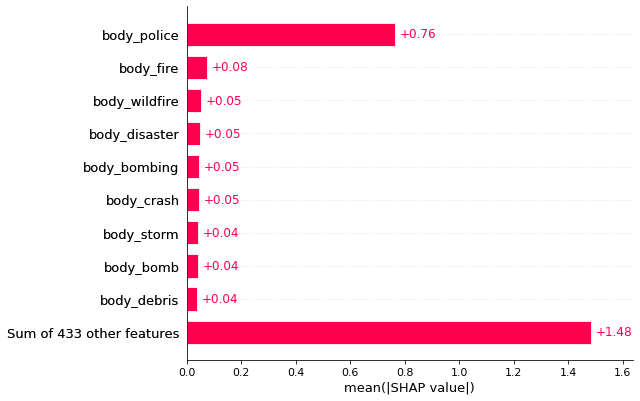

In [158]:
shap.plots.bar(shap_values)

## Spacy Sentiment

## NLP Model (RNN/LSTM/BERT)